#### In this Notebook we will use the dataset and the dataloader module to create custom datasets.
We know that a basic custom dataset in Pytorch needs to have two components.
1. It needs to return the length of the dataset from the `__len__()` method.
2. It needs to implement the `__getitem__()` method.\

To implement the dataset we need also to subclass the dataset class and override the above mentioned methods.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os
import imageio 
import random
import copy
np.random.seed(42)
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

We would build a dataset class of the cats vs dogs dataset and try to run a CNN that classifies them afterwards.

In [2]:
class CatsVDogsCustom(Dataset):
    """ This class converts the images into tensors and provides a nice interface to get images on prompt from the disk."""
    def __init__(self,is_val_set_bool = False):
        """Initialization"""
        super(Dataset, self).__init__()

        random.seed(42)
        partition_dict = {'train':[], 'val':[]}
        label_dict={}
        path = "D://Datasets/cats_vs_dogs_train_dataset/train/"
        file_list = os.listdir(path)
        random.shuffle(file_list)
        for idx in range(len(file_list)):
            if idx%10 == 0:
                filename = file_list[idx]
                image_label, image_id,_ = filename.split('.')
                partition_dict['val'].append(image_label+ '-' +image_id)
                label_dict[image_label+'-'+image_id] = image_label 
            else:
                filename = file_list[idx]
                image_label, image_id,_ = filename.split('.')
                partition_dict['train'].append(image_label+ '-'+image_id)
                label_dict[image_label+'-'+image_id] = image_label

        if is_val_set_bool:
            self.image_names_array = copy.copy(partition_dict['val'])
        else:
            self.image_names_array = copy.copy(partition_dict['train'])

        self.label_dict = label_dict


    def __len__(self):
        """ Returns the length of the train or val dataset"""
        return len(self.image_names_array)
    
    def __getitem__(self, idx):
        # Get the image from the disk and convert the image and label into a numpy array
        path = "D://Datasets/cats_vs_dogs_train_dataset/train/"
        image_name = self.image_names_array[idx]
        image = imageio.imread(path + image_name.replace('-','.')+'.jpg')
        image_array = np.array(image, dtype=np.float32)
        label = self.label_dict[self.image_names_array[idx]]
        # label_array = np.zeros((2)),dtype=np.float32)
        label_tensor = torch.zeros(2)
        label_tensor[0 if label=='cat' else 1] = 1
        

        # Now convert the image_array and the label_array into a tensor return the image_array and label_array as a tuple.
        tensor_shape = (128,128)
        image_tensor = torch.from_numpy(image_array)
        image_tensor = image_tensor.permute((2,0,1))
        image_mean = image_tensor.view(3,-1).mean(dim=1)
        image_std = image_tensor.view(3,-1).std(dim=1)
        transform  = transforms.Compose([transforms.Resize(tensor_shape), transforms.Normalize(mean=image_mean, std = image_std)])
        image_tensor = transform(image_tensor)
        # label_tensor = torch.from_numpy(label_array)

        return image_tensor, label_tensor



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


22500
tensor([[[-0.1486, -0.7042, -0.4065,  ..., -0.1704, -0.1351, -0.2028],
         [-0.3790, -0.1748, -0.2547,  ..., -0.1669, -0.1924, -0.3361],
         [-0.5583, -0.0665, -0.4218,  ...,  0.0810, -0.4238, -0.2159],
         ...,
         [-0.3939, -0.2105,  0.0419,  ..., -0.1800, -0.5341, -0.0812],
         [-0.0821, -0.5127, -0.4383,  ...,  0.9983, -0.5916, -0.6242],
         [-0.4949, -0.2734, -0.2921,  ..., -0.2736, -0.9421, -0.9760]],

        [[-0.0814, -0.5204, -0.2335,  ..., -0.1490, -0.0096, -0.1920],
         [-0.3307,  0.0191, -0.0766,  ..., -0.1467, -0.0755, -0.0467],
         [-0.5235,  0.1178, -0.2492,  ...,  0.0531, -0.3292, -0.0410],
         ...,
         [-0.6948, -0.6390, -0.2087,  ..., -0.1982, -0.4689, -0.1534],
         [-0.3848, -0.4991, -0.7055,  ...,  0.9450, -0.5987, -0.5203],
         [-0.6796, -0.1146, -0.4340,  ..., -0.3643, -0.9724, -0.9052]],

        [[-0.2940, -0.6382, -0.3233,  ..., -0.2294,  0.1042, -0.1772],
         [-0.4718, -0.1793, -0.2025,  .

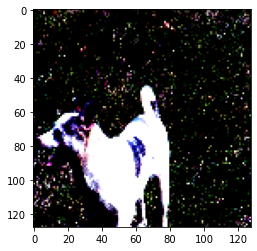

In [3]:
dataset = CatsVDogsCustom()
image_array, label_array = dataset.__getitem__(5)
print(len(dataset))
print(image_array, label_array)
print(image_array.shape)
new_array = image_array.permute(1,2,0)
plt.imshow(new_array)

In [4]:
train_dl = DataLoader(batch_size = 128, dataset= CatsVDogsCustom(),pin_memory=True)
# for batch in train_dl:
#     print(batch[0][0].shape, batch[1][0].shape)
#     # print(len(first_image_tuple))
#     break
train_dl

In [9]:
val_dl = DataLoader(batch_size = 128, dataset = CatsVDogsCustom(is_val_set_bool=True), pin_memory = True)

### Now lets define a model to train the data. First we will define a Linear Model

In [7]:
model = nn.Sequential(OrderedDict([
    ('Input Layer', nn.Linear(49152, 512)),
    ('Activation Layer', nn.Tanh()),
    ('Hidden Layer', nn.Linear(512, 256)),
    ('Activation Layer', nn.Tanh()),
    ('Output Layer', nn.Linear(256, 2)),
    ('Softmax Layer', nn.LogSoftmax(dim = 1))
]))



In [6]:
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1050 Ti'

Now lets set up a training loop to check if the data can trained by the model

In [10]:
import torch.nn
import torch.optim as optim


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())
print(device.__str__)



new_model = model.to(device=device)
print(all(p.is_cuda for p in model.parameters()))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_model.parameters(), lr = 0.01)
n_epochs = 10
def training_loop(n_epochs, train_dl, val_dl, optimizer, loss_fn, model):
    for epoch in range(1, n_epochs+1):
        if device.type == 'cuda':
            print(torch.cuda.get_device_name(0))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
            print(f"Epoch {epoch} Training")
        
        for image, label in train_dl:
            image = image.to(device=device)
            label = label.to(device = device)

            batch_size = image.shape[0]

            # We will need to flatten the image and send it to the model

            pred = model(image.view(batch_size, -1))

            loss = loss_fn(pred, label)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        print(f"Epoch : {epoch} | Loss : {loss}")
    return pred , loss

training_loop(n_epochs, train_dl , val_dl, optimizer, loss_fn, model = model)



NVIDIA GeForce GTX 1050 Ti
<method-wrapper '__str__' of torch.device object at 0x000001DC627E1FD0>
True
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.1 GB
Cached:    0.1 GB
Epoch 1 Training
Epoch : 1 | Loss : 0.6657674908638
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Epoch 2 Training
Epoch : 2 | Loss : 0.6448878049850464
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Epoch 3 Training
Epoch : 3 | Loss : 0.6265018582344055
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Epoch 4 Training
Epoch : 4 | Loss : 0.605172872543335
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Epoch 5 Training
Epoch : 5 | Loss : 0.5775793790817261
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Epoch 6 Training
Epoch : 6 | Loss : 0.5421050190925598
NVIDIA GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.2 GB
Cached:    0.3 GB
Epoch 7 Training
Epoch : 7 | Lo

(tensor([[-2.8455e-01, -1.3958e+00],
         [-1.4997e-01, -1.9714e+00],
         [-1.2979e-02, -4.3509e+00],
         [-4.3248e-02, -3.1623e+00],
         [-1.7621e+00, -1.8835e-01],
         [-1.2668e-01, -2.1287e+00],
         [-2.3247e+00, -1.0293e-01],
         [-2.9715e-01, -1.3584e+00],
         [-1.9310e+00, -1.5666e-01],
         [-2.8320e-01, -1.3999e+00],
         [-2.2176e+00, -1.1527e-01],
         [-2.1817e-01, -1.6296e+00],
         [-9.2019e-01, -5.0824e-01],
         [-6.1999e-01, -7.7208e-01],
         [-2.1730e+00, -1.2085e-01],
         [-1.2964e-02, -4.3521e+00],
         [-1.8518e+00, -1.7074e-01],
         [-1.5555e+00, -2.3709e-01],
         [-8.1371e-02, -2.5492e+00],
         [-1.8774e+00, -1.6604e-01],
         [-1.7890e+00, -1.8288e-01],
         [-1.7422e-01, -1.8333e+00],
         [-1.7101e+00, -1.9948e-01],
         [-5.2899e-02, -2.9657e+00],
         [-4.3701e-02, -3.1521e+00],
         [-1.4667e-01, -1.9920e+00],
         [-3.0129e-01, -1.3465e+00],
 

In [24]:
print(model.parameters)

<bound method Module.parameters of Sequential(
  (Input Layer): Linear(in_features=49152, out_features=512, bias=True)
  (Activation Layer): Tanh()
  (Hidden Layer): Linear(in_features=512, out_features=256, bias=True)
  (Output Layer): Linear(in_features=256, out_features=2, bias=True)
  (Softmax Layer): LogSoftmax(dim=1)
)>
